In [48]:
import numpy as np
import torch

import rlkit.torch.pytorch_util as ptu
from rlkit.torch.pearl.agent import PEARLAgent
from rlkit.torch.torch_rl_algorithm import TorchTrainer
from rlkit.data_management.multitask_replay_buffer import ObsDictMultiTaskReplayBuffer
from rlkit.misc.roboverse_utils import add_data_to_buffer_multitask_v2, get_buffer_size_multitask
from rlkit.torch.sac.policies import GaussianCNNPolicy
from rlkit.torch.networks.cnn import CNN, ConcatCNN
import roboverse

import matplotlib.pyplot as plt
import os
gpu_id = 6
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
ptu.set_gpu_mode(True)

In [2]:
#file paths
CHECKPOINT = ('/nfs/kun1/users/avi/doodad-output/'
             '21-05-26-awac-pearl-image-Widow250PickPlaceMetaTestMultiObjectMultiContainer-v0/'
             '21-05-26-awac-pearl-image-Widow250PickPlaceMetaTestMultiObjectMultiContainer-v0'
              '_2021_05_26_19_46_16_id000--s0/itr_340000.pt')
BUFFER = ('/nfs/kun1/users/avi/scripted_sim_datasets/'
          'may26_Widow250PickPlaceMetaTrainMultiObjectMultiContainer-v0_16K_save_all_noise_0.1_2021-05-26T16-12-04/'
          'may26_Widow250PickPlaceMetaTrainMultiObjectMultiContainer-v0_16K_save_all_noise_0.1_2021-05-26T16-12-04_16000.npy')
ENV = 'Widow250PickPlaceMetaTestMultiObjectMultiContainer-v0'

#agent kwargs
LATENT_DIM = 5
USE_NEXT_OBS_IN_CONTEXT = False
_DEBUG_DO_NOT_SQRT = False

#context kwargs
META_BATCH_SIZE = 4
TASK_EMBEDDING_BATCH_SIZE = 64

In [3]:
checkpoint = torch.load(CHECKPOINT)

In [24]:
expl_env = roboverse.make(ENV, transpose_image=True)
state_observation_dim = expl_env.observation_space.spaces['state'].low.size
action_dim = expl_env.action_space.low.size
reward_dim = 1
cnn_params = dict(
        input_width=48,
        input_height=48,
        input_channels=3,
        kernel_sizes=[3, 3, 3],
        n_channels=[16, 16, 16],
        strides=[1, 1, 1],
        hidden_sizes=[1024, 512, 256],
        paddings=[1, 1, 1],
        pool_type='max2d',
        pool_sizes=[2, 2, 1],  # the one at the end means no pool
        pool_strides=[2, 2, 1],
        pool_paddings=[0, 0, 0],
        image_augmentation=True,
        image_augmentation_padding=4,
    )
context_encoder_output_dim = LATENT_DIM * 2
cnn_params.update(
    added_fc_input_size=state_observation_dim + action_dim + reward_dim,
    output_size=context_encoder_output_dim,
    hidden_sizes=[256, 256],
)
context_encoder = ConcatCNN(**cnn_params).to(ptu.device)
context_encoder.load_state_dict(checkpoint['trainer/context_encoder'])
context_encoder.to(ptu.device)

ConcatCNN(
  (hidden_activation): ReLU()
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_norm_layers): ModuleList()
  (pool_layers): ModuleList(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=2323, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc_norm_layers): ModuleList()
  (last_fc): Linear(in_features=256, out_features=10, bias=True)
)

In [5]:
train_task_indices = list(range(32))
observation_keys = ['image', 'state']
with open(BUFFER, 'rb') as fl:
    data = np.load(fl, allow_pickle=True)
num_transitions = get_buffer_size_multitask(data)
max_replay_buffer_size = num_transitions + 10

replay_buffer = ObsDictMultiTaskReplayBuffer(
    max_replay_buffer_size,
    expl_env,
    train_task_indices,
    use_next_obs_in_context=False,
    sparse_rewards=False,
    observation_keys=observation_keys
)
add_data_to_buffer_multitask_v2(data, replay_buffer, observation_keys)

In [25]:
agent = PEARLAgent(
    LATENT_DIM,
    context_encoder,
    None,
    None,
    obs_keys=observation_keys,
    use_next_obs_in_context=USE_NEXT_OBS_IN_CONTEXT,
    _debug_do_not_sqrt=_DEBUG_DO_NOT_SQRT,
)

In [31]:
task_indices = np.random.choice(
    train_task_indices, META_BATCH_SIZE,
)
contexts = (
    replay_buffer.sample_context(
    task_indices,
    TASK_EMBEDDING_BATCH_SIZE,
))
task_embeddings = agent.latent_posterior(contexts)

In [71]:
#visualization params
NUM_TASKS = 2
NUM_POINTS_PER_TASK = 100
COLORS = ('blue', 'green', 'red', 'black')

In [76]:
task_indices = np.random.choice(
    train_task_indices, NUM_TASKS,
)
embedding_means = []
for i in range(NUM_POINTS_PER_TASK):
    contexts = (
        replay_buffer.sample_context(
        task_indices,
        TASK_EMBEDDING_BATCH_SIZE,
    ))
    task_embeddings = agent.latent_posterior(contexts)
    embedding_means.append(task_embeddings.mean.detach().cpu().numpy())
print("Task Indices:", task_indices)

Task Indices: [27 16]


In [94]:
index_pairs = []
for i in range(LATENT_DIM - 1):
    for j in range(i+1, LATENT_DIM):
        index_pairs.append((i, j))

10


Task Indices: [27 16]


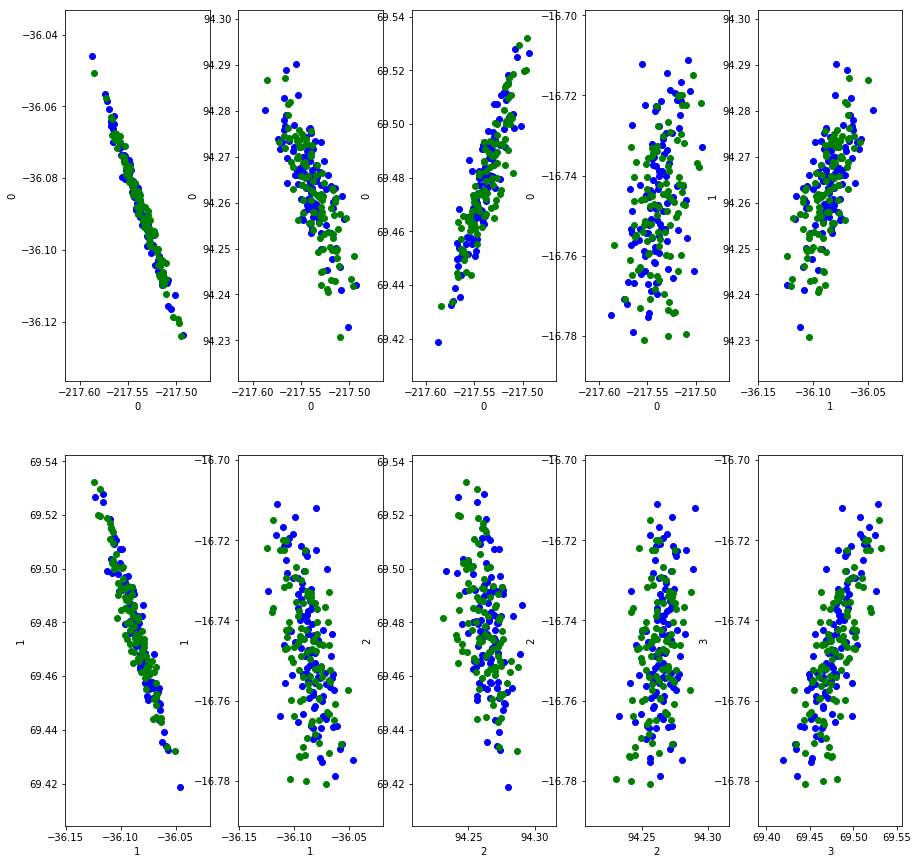

In [105]:
fig, axs = plt.subplots(2, 5, figsize=(15,15))
scaling = 10 ** 5
print("Task Indices:", task_indices)
for counter, indices in enumerate(index_pairs):
    for idx, task in enumerate(task_indices):
        x = [mean[idx, indices[0]] * scaling for mean in embedding_means]
        y = [mean[idx, indices[1]] * scaling for mean in embedding_means]
        axs[counter // 5, counter % 5].scatter(x, y, c=COLORS[idx])
        axs[counter // 5, counter % 5].set_xlabel(str(indices[0]))
        axs[counter // 5, counter % 5].set_ylabel(str(indices[0]))

plt.show()